# Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (2018)

출처: [https://arxiv.org/pdf/1804.10959.pdf](https://arxiv.org/pdf/1804.10959.pdf)

## Abstract

subword 단위는 Neural Machine Translation (NMT)에서 open vocabulary problem를 완화하는 효과적인 방법입니다. 문장은 일반적으로 고유한 subword 시퀀스로 변환되지만 subword 분할은 잠재적으로 모호하고 동일한 어휘로도 여러 분할이 가능합니다. 이 논문에서 다루는 문제는 분할의 모호성을 잡음으로 활용하여 NMT의 robustness을 향상시킬 수 있는지 여부입니다. 우리는 훈련 중에 확률적으로 샘플링된 여러 subword segmentation으로 모델을 훈련하는 간단한 정규화 방법인 subword regularization를 제시합니다. 또한, 더 나은 subword sampling을 위해 unigram language model을 기반으로 하는 새로운 subword segmentation algorithm을 제안합니다. 우리는 여러 corpus를 실험하고 특히, 리소스 부족 및 out-of-domain steetings에서 일관되게 모델이 개선된 것을 보여줍니다.

## 1 Introduction

Neural Machine Translation (NMT) 모델은 훈련 및 추론이 어휘 크기에 크게 의존하기 때문에 고정 단어로 실행하는 경우가 많습니다. 그러나 어휘 크기를 제한하면 알 수 없는 단어의 양이 증가하여 특히 open vocabulary setting에서 번역이 부정확해집니다.

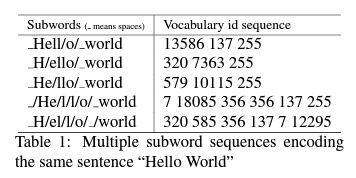

open vocabulary issue를 다루는 일반적인 접근 방식은 rare word를 subword 단위로 나누는 것입니다. Byte-Pair-Encoding (BPE)은 많은 NMT 시스템에 적용되고 여러 작업에서 최고의 번역 품질을 달성하는 사실상의 standard subword segmentation algorithm입니다. BPE segmentation은 어휘 크기와 decoding 효율성 사이에 좋은 balance를 제공하고 unknown words에 대한 특별한 처리의 필요성을 피하게 합니다.

BPE는 문장을 고유한 subword sequence로 인코딩합니다. 하지만, 문장은 동일한 어휘라도 여러 subword sequence로 표현될 수 있습니다. Table 1은 그 예를 보여줍니다. 이러한 시퀀스는 동일한 input "Hello World"를 인코딩하지만, NMT는 완전히 다른 입력으로 처리합니다. NMT 훈련 시 multiple segmentation candidates는 모델이 단어의 구성을 학습하는 데 간접적으로 도움이 될 수 있으므로 노이즈 및 segmentation 오류에 대해 모델을 견고하게 만듭니다.

이 연구에서는 NMT 모델을 정확하고 견고하게 만들기 위해 multiple subword segmentation을 사용하는 **subword regularization**이라고 하는 open-vaocabulary NMT에 대한 새로운 regularization 방법을 제안합니다. subword regularization은 다음 두 가지로 구성됩니다:

<br/>

- multiple segmentation candidates를 통합하기 위한 간단한 NMT 훈련 알고리즘
- 확률을 가지는 multiple segmentation을 제공하는 언어 모델을 기반으로 하는 새로운 subword segmentation algorithm

## 2 Neural Machine Translation with multiple subword segmentations

### 2.1 NMT training with on-the-fly subword sampling

source sentence는 $X$, target sentence는 $Y$가 주어졌을 때, $\mathbf{x}=\left(x_{1}, \ldots, x_{M}\right)$, $\mathbf{y}=\left(y_{1}, \ldots, y_{N}\right)$를 각각에 해당하는 subword sequence라고 합니다.

NMT는 번역 확률을 $P(Y \mid X)=P(\mathbf{y} \mid \mathbf{x})$로 target language sequence 모델을 모델링합니다. 이는 target history $y_{<n}$과 source input sequence $x$를 통해 target subowrd $y_n$을 만듭니다:

$$P(\mathbf{y} \mid \mathbf{x} ; \theta)=\prod_{n=1}^{N} P\left(y_{n} \mid \mathbf{x}, y_{<n} ; \theta\right)$$

$\theta$는 model parameters의 집합입니다. 

subword $y_n$을 예측하기 위해 보통 RNN 아키텍처를 사용하지만, subword regularization은 다른 아키텍처 외에도 적용이 가능합니다.

NMT는 standard MLE를 통해 학습합니다. 즉, log likelihood $\mathcal{L}(\theta)$를 corpus $D$가 주어졌을 때, 최대화합니다.

$$D=\left\{\left(X^{(s)}, Y^{(s)}\right)\right\}_{s=1}^{|D|}=\left\{\left(\mathbf{x}^{(s)}, \mathbf{y}^{(s)}\right)\right\}_{s=1}^{|D|}$$

$$\theta_{M L E}=\arg \max _{\theta} \mathcal{L}(\theta)$$

$$\text { where, } \mathcal{L}(\theta)=\sum_{s=1}^{|D|} \log P(\mathbf{y} \mid \mathbf{x} ; \theta)$$

여기서는 source와 target sentence $X$, $Y$가 확률 $P(\mathbf{x} \mid X)$ $P(\mathbf{y} \mid Y)$를 통해 다양한 subword sequences로 segment될 수 있다고 가정합니다.

sub word regularization에서 parameter set인 $\theta$를 marglianlized likelihood로 최적화를 합니다:

$$\mathcal{L}_{\text {marginal }}(\theta)=\sum_{s=1}^{|D|} \mathbb{E}_{\mathbf{x} \sim P\left(\mathbf{x} \mid X^{(s)}\right), \mathbf{y} \sim P\left(\mathbf{y} \mid Y^{(s)}\right)}[\log P(\mathbf{y} \mid \mathbf{x} ; \theta)]$$

정확한 최적화는 가능한 segmentation 수가 문장 길이와 관련하여 기하급수적으로 증가하기 때문에 실현 가능하지 않습니다. 따라서, 위의 식을 $P(\mathrm{x} \mid \mathrm{X})$와 $P(\mathrm{y} \mid \mathrm{Y})$로부터 sample된 유한한 k개의 sequences로 근사합니다.

$$\mathcal{L}_{\text {marginal }}(\theta) \approx \frac{1}{k^{2}} \sum_{s=1}^{|D|} \sum_{i=1}^{k} \sum_{j=1}^{k} \log P\left(\mathbf{y}_{j} \mid \mathbf{x}_{i} ; \theta\right)$$

$$\mathbf{x}_{i} \sim P\left(\mathbf{x} \mid X^{(s)}\right), \mathbf{y}_{j} \sim P\left(\mathbf{y} \mid Y^{(s)}\right)$$

간단함을 위해, 여기선 $k=1$을 사용합니다. $D$의 subset (mini-batch)를 통해 parameter $\theta$를 반복을 통해 최적화합니다.

### 2.2 Decoding

NMT의 decoding에서는, raw source 문장 $X$만을 가집니다. decoding의 쉬운 접근 방법은 best segmentation $P(\mathbf{x} \mid X)$를 최대화하는 $x^*$로부터 번역을 하는 것입니다. 즉, $\mathbf{x}^{*}=\arg \max _{\mathbf{x}} P(\mathbf{x} \mid X)$입니다. 추가적으로, 여러개의 subword segmentation을 고려하기 위해 $P(\mathbf{x} \mid X)$의 n-best segmentation을 사용할 수 있습니다. 더 구체적으로, n-best segmentation $\left(\mathbf{x}_{1}, \ldots, \mathbf{x}_{n}\right)$가 주어졌을 때, 아래의 score를 최대화하는 best translation $y^∗$를 선택할 수 있습니다.

$$\operatorname{score}(\mathbf{x}, \mathbf{y})=\log P(\mathbf{y} \mid \mathbf{x}) /|\mathbf{y}|^{\lambda}$$

이때, $\left\vert \mathbf{y} \right\vert$는 $y$의 subword의 개수이고, $\lambda \in \mathbb{R}^{+}$는 짧을 문장에 패널티를 줍니다.

## 3 Subword segmentations with language model 

### 3.1 Byte-Pair-Encoding (BPE)

BPE는 확률을 가지는 다양한 segmentation을 제공할 수 없다는 단점이 있습니다. 따라서, segmentation 확률 $P(x|X)$에 의존하는 subword regularization에 BPE를 적용하는 것은 간단하지 않습니다.

### 3.2 Unigram language model

unigram language model은 다음과 같은 가정을 합니다. 각각의 subword는 독립적이고 연속적으로 발생하고, subword sequence $\mathbf{x}=\left(x_{1}, \ldots, x_{M}\right)$은 subword의 발생 확률 $p\left(x_{i}\right)$의 곱으로 형성됩니다(target sequence $y$에 대해서도 동일하게 적용 가능).

$$\begin{array}{c}
P(\mathbf{x})=\prod_{i=1}^{M} p\left(x_{i}\right) \\
\forall i, x_{i} \in \mathcal{V}, \sum_{x \in \mathcal{V}} p(x)=1
\end{array}$$

이때 $\mathcal{V}$는 미리 결정된 단어 사전입니다. input 문장 $X$에 대해 가장 가능성 높은 segmentation $x^∗$은 다음과 같이 주어집니다.

$$\mathbf{x}^{*}=\arg \max _{\mathbf{x} \in S(X)} P(\mathbf{x})$$

이때 $S(X)$는 input 문장 $X$로부터 생성된 segmentation의 후보 집합입니다. $x^∗$는 Viterbi algorithm (Viterbi, 1967)을 통해 얻어집니다.

만약 단어 사전 $\mathcal{V}$가 주어진다면, subword 발생 확률들인 $p\left(x_{i}\right)$가 EM algorithm을 통해 추정된다. 이때 EM algorithm은 다음의 marginal likelihood 함수 $\mathcal{L}$을 $p\left(x_{i}\right)$가 hidden variable이라고 간주하고 최대화합니다.

$$\mathcal{L}=\sum_{s=1}^{|D|} \log \left(P\left(X^{(s)}\right)=\right.\sum_{s=1}^{|D|} \log \left(\sum_{\mathbf{x} \in S\left(X^{(s)}\right)} P(\mathbf{x})\right)$$

하지만, 실제의 경우에는 단어 집합 $\mathcal{V}$의 크기를 알 수 없습니다. 단어 집합과 그들의 발생 확률의 joint optimization이 다루기 힘들기 때문에, 다음과 같은 반복적인 algorithm을 고려합니다.

1. Heuristically, 충분히 큰 seed의 단어 사전을 training corpus로부터 만듭니다. = make a reasonably big seed vocabulary from the training corpus.
2. 다음의 과정을 $\left\vert \mathcal{V} \right\vert$가 목표로하는 단어 사전 크기가 될때까지 반복합니다.
    - 단어 사전을 고정하고, $p(x)$를 EM algorithm을 이용해 최적화합니다.
    
    <br/>
    - 각각의 subword $x_i$에 대한 $\operatorname{loss}_{i}$를 계산합니다. 이때 $\operatorname{loss}_{i}$는 현재 단어 사전에서 subword $x_i$가 제거 되었을 때, likelihood $\mathcal{L}$이 얼마나 감소하는지를 나타냅니다.
    <br/>
    
    - symbol들을 $\operatorname{loss}_{i}$을 이용해 정렬하고, 상위 $\eta$% 만큼의 subword만을 유지합니다($\eta$는 예를 들어 80). subwords를 항상 out-of-vocabulary 문제를 피하기 위해 single character로 유지해야 한다는 것을 명심해야합니다.


<br/>
<br/>

seed 단어 사전을 준비하기 위한 다양한 방법들이 있습니다. 가장 일반적인 방법은 corpus에 속하는 모든 character(음절)과 가장 빈도가 높은 substrings들로 단어 사전을 만드는 것입니다(이는 BPE 알고리즘을 통해 만들 수 있다).

최종 단어 사전 $\mathcal{V}$가 corpus에 속하는 모든 character(음절)을 포함하므로, 모든 segmentation 후보 $S(X)$에 character-based segmentation 또한 포함됩니다. 다르게 말하면, unigram language model을 통한 subword segmentation은 characters, subwords, 그리고 word segmentations들의 확률 조합이라고 생각할 수 있습니다.

### 3.3 Subword sampling

Subword regularization은 각 parameter update에서 $P(\mathbf{x} \mid X)$ 분포를 통해 하나의 subword segmentation을 sampling합니다. 가장 직관적인 접근은 $l$-best segmentation을 $P(\mathbf{x} \mid X)$ 확률에 따라 얻는 것입니다. $l$-best search는 Forward-DP Backward-$A^*$ 알고리즘을 통해 선형 시간 내에 수행될 수 있습니다. 하나의 segmentation $P\left(\mathbf{x}_{i} \mid X\right) \cong P\left(\mathbf{x}_{i}\right)^{\alpha} / \sum_{i=1}^{l} P\left(\mathbf{x}_{i}\right)^{\alpha}$를 통해 sampling됩니다. 이때 $α∈R^{+}$는 분포의 smoothness를 결정하는 hyperparameter입니다. $α$가 작을수록, uniform distribution에서 sampling하는 것과 비슷하고, $α$가 클수록 Viterbi segmentation을 선택하는 경향이 높습니다.

$l \rightarrow \infty$일 때, 이론적으로는 모든 가능한 segmentation을 고려하게 됩니다. 하지만 문장의 길이가 길어질수록 후보의 개수가 지수적으로 증가하므로 $l$
을 증가시키기 어렵습니다. 모든 가능한 segmentation으로부터 sampling을 하기 위해, Forward-Filtering and Backward-Sampling algorithm (FFBS) (Scott, 2002)를 사용했습니다.

## 6 Conclusions

이 논문에서는 네트워크 아키텍처를 변경하지 않고 NMT에 대한 간단한 regularization 방법인 subword regularization을 제시했습니다. 핵심 아이디어는 NMT 모델의 정확성과 robustness를 향상시키는 데 도움이 되는 on-the-fly subword sampling으로 훈련 데이터를 증가시키는 것입니다. 또한, 더 나은 subword sampling을 위해 unigram language model을 기반으로 하는 새로운 subword segmentation algorithm을 제안합니다. 크기와 언어가 다른 여러 corpus에 대한 실험은 subword regularization가 특히 resource가 적고 open-domain settings에서 상당한 개선을 가져온다는 것을 보여줍니다.

향후 다른 작업을 위한 유망한 방법은 인코더-디코더 아키텍처를 기반으로 하는 다른 NLP 작업(예: 대화 생성 및 자동 요약)에 subword regularization를 적용하는 것입니다. machine translation에 비해 지금까지의 작업은 훈련 데이터가 충분하지 않으므로 subword regularization을 통한 큰 개선의 여지가 있을 수 있습니다. 또한 Denoising AutoEncoder 및 Adversarial Training을 포함하여 machine learning을 위한 subword regularization의 적용을 탐구하자 합니다.

----------------------------
참고

[https://an-seunghwan.github.io/nlp/Subword-Regularization(%EB%85%BC%EB%AC%B8-%EC%9D%BD%EA%B8%B0)/](https://an-seunghwan.github.io/nlp/Subword-Regularization(%EB%85%BC%EB%AC%B8-%EC%9D%BD%EA%B8%B0)/)